In [1]:
import numpy as np
from cs231n import optim
import matplotlib.pyplot as plt
import tensorflow as tf

from cs231n.layers import *
from cs231n.rnn_layers import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [3]:
# Parameters for the model and dataset.
TRAINING_SIZE = 10000
DIGITS = 20
INVERT = False

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 2

# All the numbers, plus sign and space for padding.
chars = '0123456789se '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, 12))))
    a = f()
    b = a
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = (a, b)
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = 's{}e'.format(a)
    query = q + ' ' * (MAXLEN - len(q))
    ans = 's{}e'.format(b)
    # Answers can be of maximum size DIGITS + 1.
    ans = ans + ' ' * (MAXLEN - len(ans))
    if INVERT:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        ans= ans[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.int32)
y = np.zeros((len(questions), MAXLEN), dtype=np.int32)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = np.array([ctable.char_indices[z] for z in sentence])

    
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
# because it is sorted
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Generating data...
('Total addition questions:', 10000)
Vectorization...
Training Data:
(9000, 22, 13)
(9000, 22)
Validation Data:
(1000, 22, 13)
(1000, 22)


In [63]:
print (x_train[0], y_train[0])

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [4]:
D = len(chars)
C = len(chars)
T = MAXLEN
N = 5
H = 50
num_epochs = 5
num_batches = x_train.shape[0]//N
batch_size = N

In [5]:
tf.reset_default_graph()

batchX_placeholder = tf.placeholder(tf.float32, [None,T,D], name='x_batch')
batchY_placeholder = tf.placeholder(tf.int32, [None,T], name='y_batch')

N = tf.shape(batchX_placeholder)[0]
cell_state = tf.zeros([N,H], dtype=tf.float32)
hidden_state = tf.zeros([N,H], dtype=tf.float32)
init_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)

W2 = tf.Variable(np.random.rand(H,C),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,C)), dtype=tf.float32)

Wc = tf.Variable(np.random.rand(H,T),dtype=tf.float32, name='wc')
bc = tf.Variable(np.zeros((1,T)), dtype=tf.float32, name='bc')

# Forward passes
with tf.variable_scope('rnn1'):
    cell = tf.contrib.rnn.BasicLSTMCell(H, state_is_tuple=True)
    #cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5)
    states_series, current_state = tf.nn.dynamic_rnn(cell, batchX_placeholder, initial_state=init_state)

losses = []
attn = []
predictions = []
with tf.variable_scope('rnn2'):
    cell = tf.contrib.rnn.BasicLSTMCell(H, state_is_tuple=True, reuse=tf.get_variable_scope().reuse)
    #cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5)
    current_input = tf.zeros([N,D], dtype=tf.float32)
    current_input += (ctable.encode('s',1)).astype(np.float32)
    for t in range(T):
        
        c = tf.tanh(tf.matmul(current_state.h, Wc) + bc)
        a = tf.nn.softmax(c)
        b = tf.reshape(a, [N,T,1])
        attn_i = tf.reduce_sum(tf.multiply(batchX_placeholder,b), axis=-2)
        
        if t > 0: tf.get_variable_scope().reuse_variables()
        states_series, current_state = cell(tf.concat([attn_i, current_input], axis=1), current_state)
        logits = tf.matmul(states_series, W2) + b2
        labels = tf.reshape(batchY_placeholder[:,t], [-1])
        losses.append(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
        prob = tf.nn.softmax(logits)
        pred = tf.one_hot(tf.argmax(prob, axis=1), C, axis=-1)
        predictions.append(pred)
        current_input = pred
        attn.append(a)

predictions = tf.stack(predictions, axis=1, name='pred')
attn = tf.stack(attn, axis=1, name='attn')
print (attn.shape)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

(?, 22, 22)


In [6]:
saver = tf.train.Saver()
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        sess.run(tf.global_variables_initializer())
        loss_list = []

        for epoch_idx in range(num_epochs):
            print("New data, epoch", epoch_idx)

            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size

                batchX = x_train[start_idx:end_idx]
                batchY = y_train[start_idx:end_idx]

                _total_loss, _train_step, batchP = sess.run(
                    [total_loss, train_step, predictions],
                    feed_dict={
                        batchX_placeholder: batchX,
                        batchY_placeholder: batchY
                    })

                loss_list.append(_total_loss)

                if batch_idx%100 == 0:
                    print("Step",batch_idx, "Batch loss", _total_loss)
                    #plot(loss_list, _predictions_series, batchX, batchY)
            
            batchX = x_val
            batchY = y_val

            batchP = sess.run(
                predictions,
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY
                })
            w = [''.join(ctable.indices_char[i] for i in batchY[j]) for j in range(x_val.shape[0])]
            q = [ctable.decode(batchP[i]) for i in range(x_val.shape[0])]
            correct_examples = 0
            for i,j in zip(w,q):
                if (i==j):
                    correct_examples += 1
            print ('Validation accuracy', float(correct_examples)/x_val.shape[0])
            
            batchX = x_train
            batchY = y_train

            batchP = sess.run(
                predictions,
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY
                })
            w = [''.join(ctable.indices_char[i] for i in batchY[j]) for j in range(x_train.shape[0])]
            q = [ctable.decode(batchP[i]) for i in range(x_train.shape[0])]
            correct_examples = 0
            for i,j in zip(w,q):
                if (i==j):
                    correct_examples += 1
            print ('Training accuracy', float(correct_examples)/x_train.shape[0])
            
        saver.save(sess, 'my-model')

('New data, epoch', 0)
('Step', 0, 'Batch loss', 2.5542836)
('Step', 100, 'Batch loss', 1.5750238)
('Step', 200, 'Batch loss', 1.2699211)
('Step', 300, 'Batch loss', 0.74067146)
('Step', 400, 'Batch loss', 0.8095988)
('Step', 500, 'Batch loss', 0.60331637)
('Step', 600, 'Batch loss', 0.6529308)
('Step', 700, 'Batch loss', 0.8695035)
('Step', 800, 'Batch loss', 0.53027385)
('Step', 900, 'Batch loss', 0.43653715)
('Step', 1000, 'Batch loss', 0.6428864)
('Step', 1100, 'Batch loss', 0.49383268)
('Step', 1200, 'Batch loss', 0.72695577)
('Step', 1300, 'Batch loss', 0.59112251)
('Step', 1400, 'Batch loss', 0.38127917)
('Step', 1500, 'Batch loss', 0.43739784)
('Step', 1600, 'Batch loss', 0.37329984)
('Step', 1700, 'Batch loss', 0.67683703)
('Validation accuracy', 0.527)
('Training accuracy', 0.5477777777777778)
('New data, epoch', 1)
('Step', 0, 'Batch loss', 0.21668474)
('Step', 100, 'Batch loss', 0.21020064)
('Step', 200, 'Batch loss', 0.36926723)
('Step', 300, 'Batch loss', 0.11497609)
('St

INFO:tensorflow:Restoring parameters from ./my-model


INFO:tensorflow:Restoring parameters from ./my-model


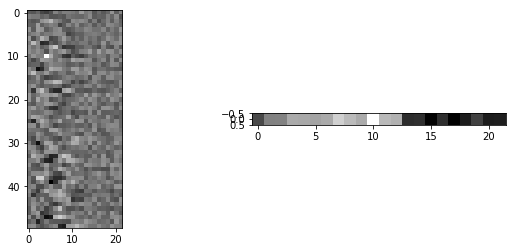

0
('Failure at ', 's12345678901234e      ', 's1234567890102e       ')


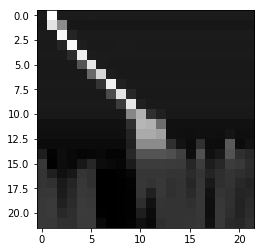

SUCCESS!!!!!


In [9]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('my-model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    a = 12345678901234
    q = 's'+ str(a) + 'e' + ' '*(MAXLEN-len(str(a))-2)
    batchX = np.reshape(ctable.encode(q, MAXLEN),(1,MAXLEN,C))
    
    graph = tf.get_default_graph()
    x_batch = graph.get_tensor_by_name("x_batch:0")
    pred = graph.get_tensor_by_name("pred:0")
    attn = graph.get_tensor_by_name("attn:0")
    wc = graph.get_tensor_by_name("wc:0")
    bc = graph.get_tensor_by_name("bc:0")
    
    Wc, Bc = sess.run(
                [wc, bc]
            )
    
    plt.subplot(1, 2, 1)
    plt.imshow(Wc)
    plt.subplot(1, 2, 2)
    plt.imshow(Bc)
    plt.gcf().set_size_inches(10, 4)
    plt.show()
    
    
    for i in range(1):
        if i%1== 0:
            print (i)
        batchP, batchA = sess.run(
                [pred,attn] ,
                feed_dict={
                    x_batch: batchX
                })
        #a += 1
        b = 's'+str(a)+'e'+(' ')*(MAXLEN-len(str(a))-2)
        q = ctable.decode(batchP[0])
        if b!=q:
            print ('Failure at ',b,q)
            q = b[::-1]
        else:
            q = q[::-1]
        batchX = np.reshape(ctable.encode(' '*(MAXLEN-len(str(a))-2) + 's'+ str(a) + 'e', MAXLEN),(1,MAXLEN,C))
        
        plt.subplot(1, 1, 1)
        plt.imshow(batchA[0])
        plt.gcf().set_size_inches(10, 4)
        plt.show()
    
    print ('SUCCESS!!!!!')
    
    '''
    w = [''.join(ctable.indices_char[i] for i in batchY[j]) for j in range(x_train.shape[0])]
    q = [ctable.decode(batchP[i]) for i in range(x_train.shape[0])]
    correct_examples = 0
    for i,j in zip(w,q):
        if (i==j):
            correct_examples += 1
        else :
            print (i,j)
    
    print ('Validation accuracy', float(correct_examples)/x_train.shape[0])
    '''
    